In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange

In [3]:
data = np.loadtxt('linear.csv', delimiter=',')
print('数据集大小', len(data))
x = data[:, :2]
y = data[:, 2]

数据集大小 200


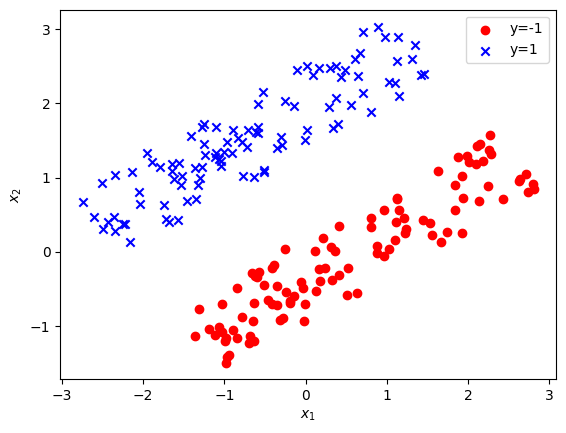

In [5]:
# 数据集可视化
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], color='blue', label='y=1', marker='x')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

In [7]:
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x,y: 样本的值和类别
    ker: 核函数
    C: 惩罚参数
    max_iter: 最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)

    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])

    for l in trange(max_iter):
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j,并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])

            # 用-q/2p更新alpha_i的值
            eta = K[j, j]+K[i, i]-2*K[i, j]  # 分母
            e_i = np.sum(y*alpha*K[:, i])-y[i]  # 分子
            e_j = np.sum(y*alpha*K[:, j])-y[j]
            alpha_i = alpha[i]+y[i]*(e_j-e_i)/(eta+1e-5)  # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0<=(zeta-y_j*alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta/y[i]-C)
                upper = min(C, zeta/y[i])
            else:
                lower = max(0, zeta/y[i])
                upper = min(C, zeta/y[i]+C)

            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]

            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j
    return alpha

In [8]:
# 设置超参数
C = 1e8
max_iter = 1000
np.random.seed(0)

alpha = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

100%|██████████| 1000/1000 [00:04<00:00, 213.30it/s]


In [9]:
# 用alpha计算w,b和支持向量
sup_idx = alpha > 1e-5
print('支持向量个数', np.sum(sup_idx))
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
wx = x @ w.reshape(-1, 1)
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1]))
print('参数:', w, b)

支持向量个数 6
参数: [-1.0211867   1.66445549] -1.3127020970395462


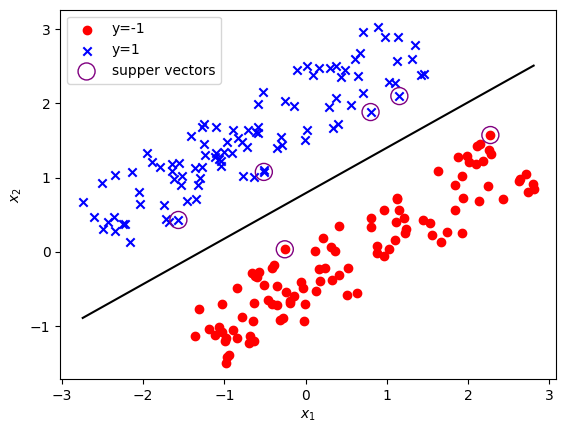

In [11]:
# 绘图
X = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
Y = -(w[0] * X + b) / (w[1] + 1e-5)
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.plot(X, Y, color='black')
# 用圆圈标记出支持向量
plt.scatter(x[sup_idx, 0], x[sup_idx, 1], marker='o', color='none',
            edgecolors='purple', s=150, label='supper vectors')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()